In [1]:
%matplotlib notebook

In [2]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [3]:
plotly.tools.set_credentials_file(username='ujjwal9', api_key='8wqtWbesK6QJO3yVhnL4')

In [4]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -   
                          slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - 
                          slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

<IPython.core.display.Javascript object>


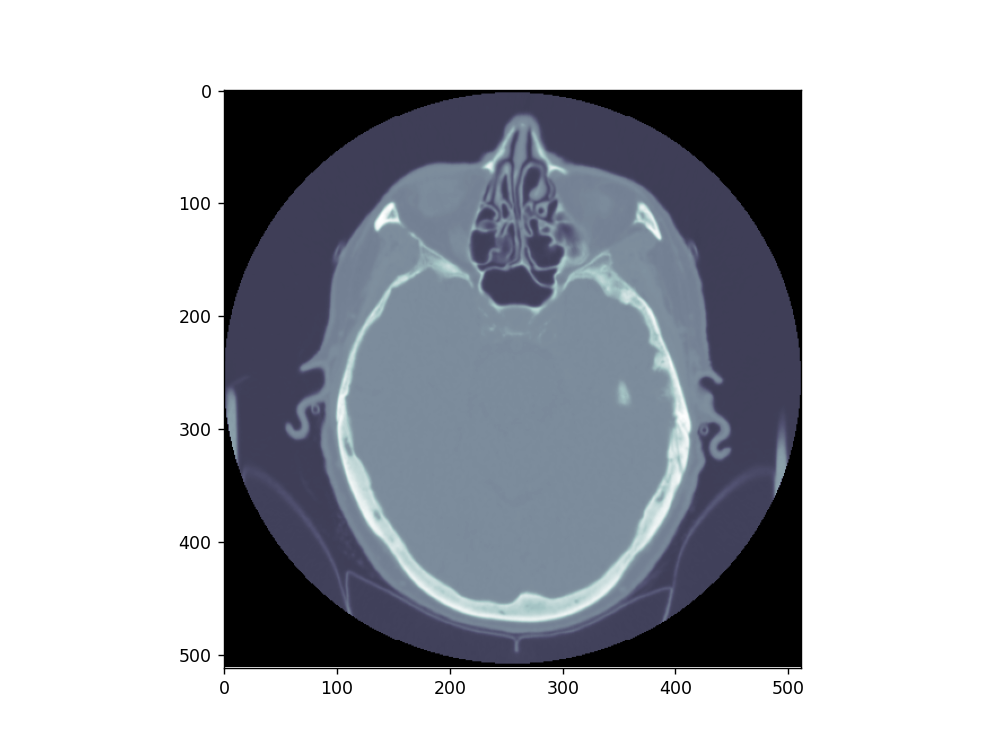

In [5]:
path = '/home/ujjwal/Projects/medical-training/RSNA/qer-2.0/Bryan_M_Hong/Qer_Report/Head_20_5'
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[23], cmap=plt.cm.bone)

In [6]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

<IPython.core.display.Javascript object>


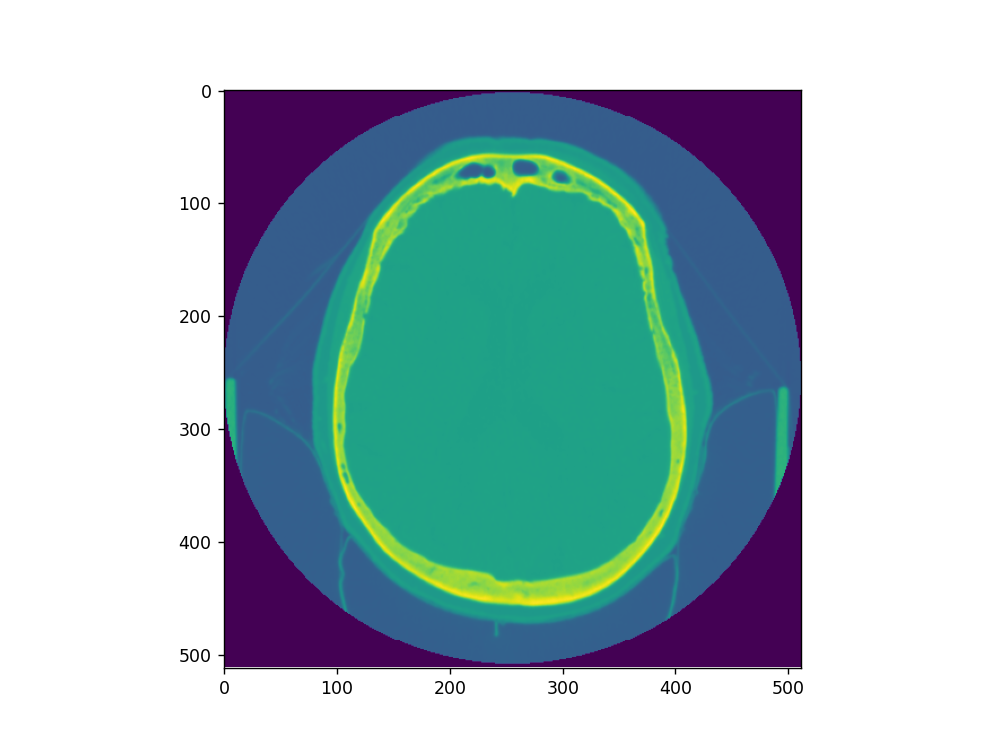

9

In [7]:
fig, ax = plt.subplots()
ax.imshow(patient_pixels[43])
fig.canvas.mpl_connect('key_press_event', process_key)

In [8]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

<IPython.core.display.Javascript object>


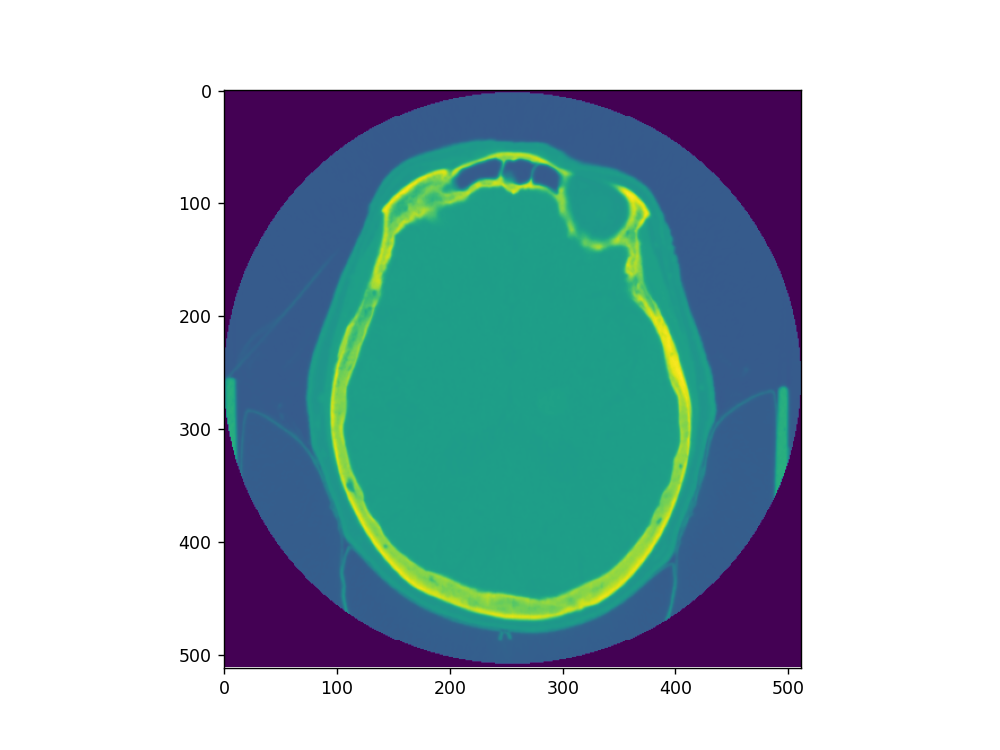

In [9]:
# press J to move to previous slice and K to move to next slice.
multi_slice_viewer(patient_pixels)

In [10]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print( "Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
#     face_color = [1, 1, 0.9]
#     mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


<IPython.core.display.Javascript object>


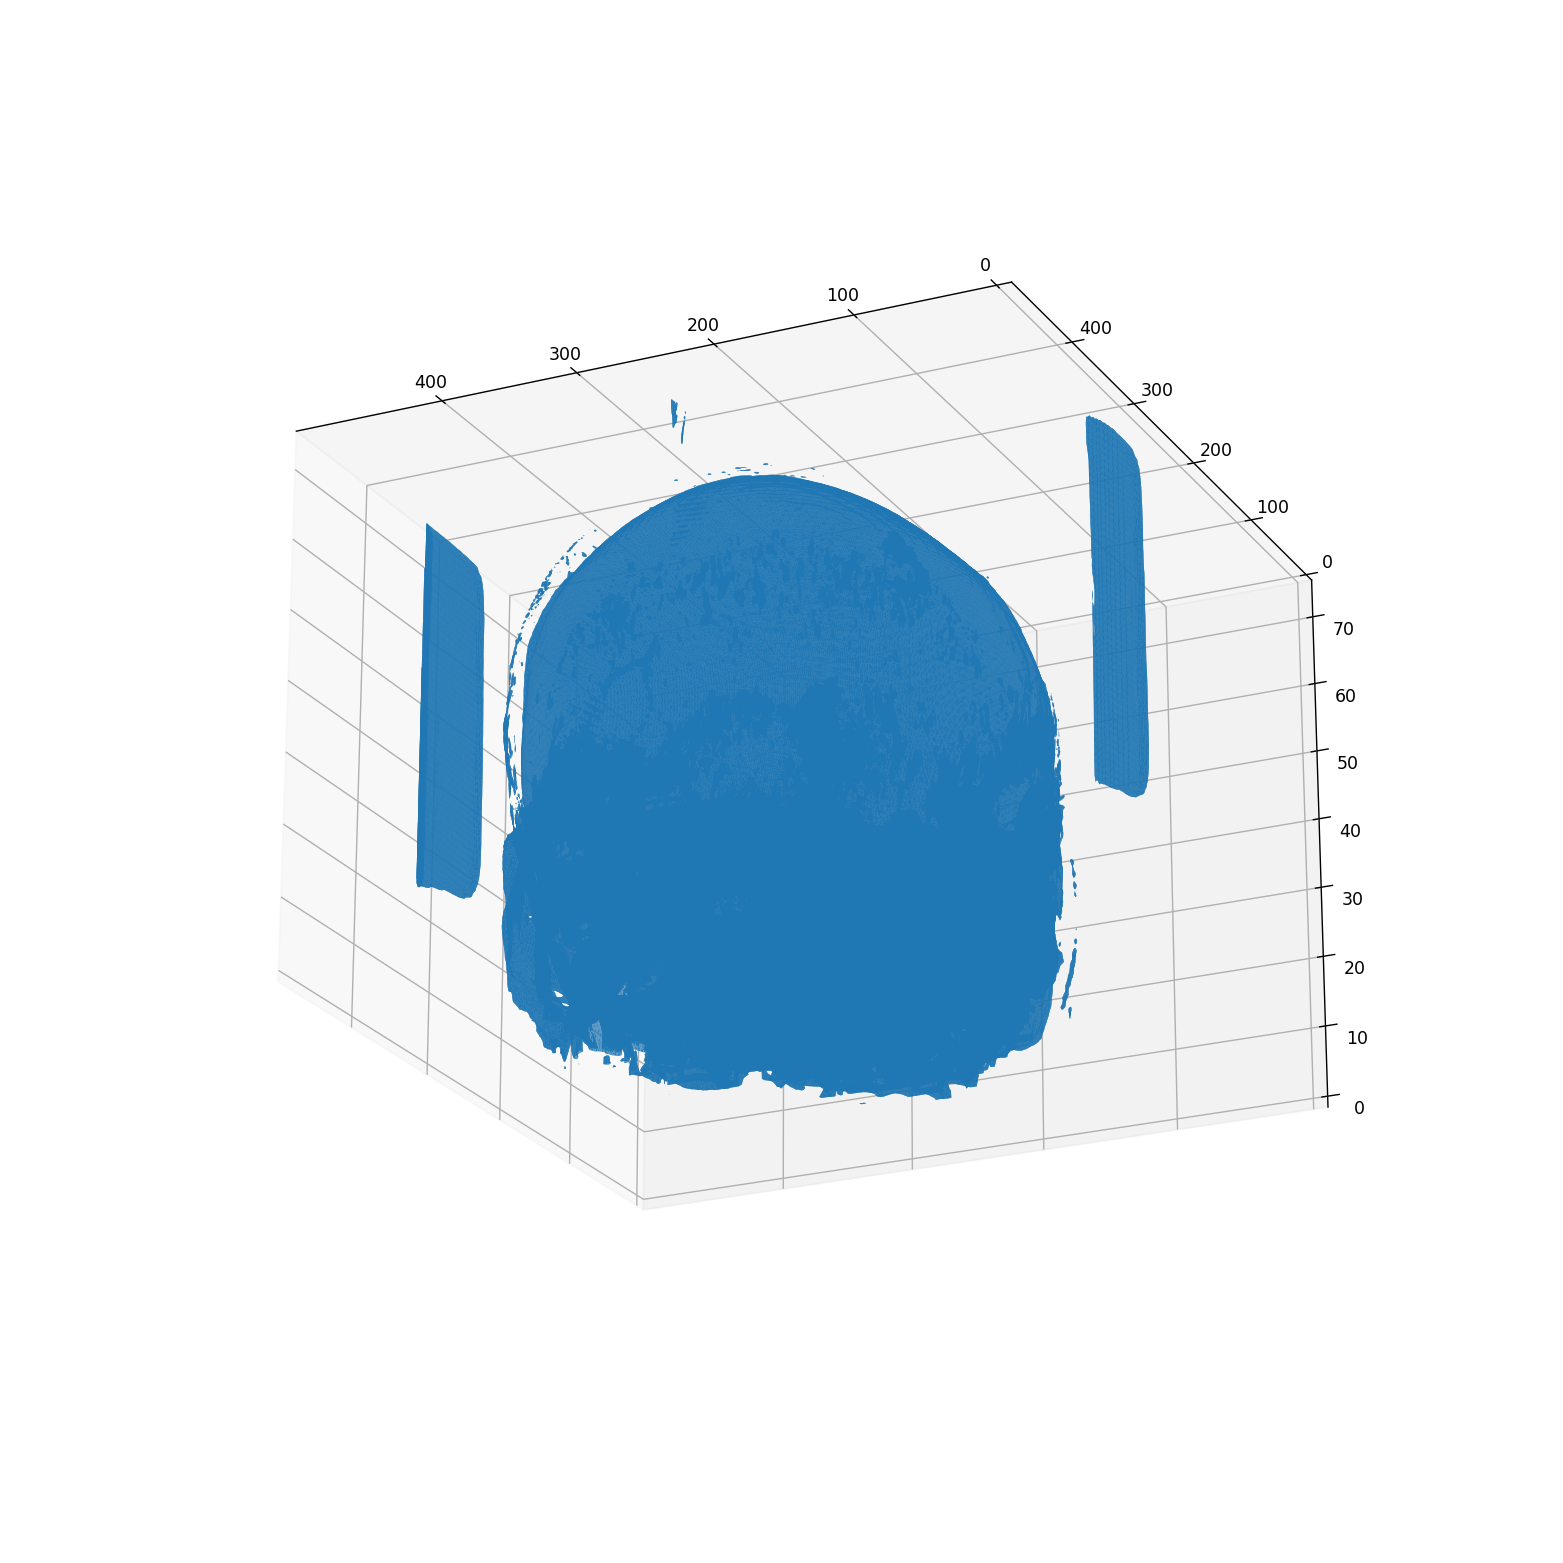

In [11]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
v, f = make_mesh(patient_pixels, 0)
plt_3d(v, f)